# **Train Object Detection Model**

#### 1. Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import xml.etree.ElementTree as xet

In [3]:
os.chdir('/content/drive/MyDrive/Number_plate/')

In [4]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./images\N1.xml,1093,1396,645,727
1,./images\N100.xml,134,301,312,350
2,./images\N101.xml,31,139,128,161
3,./images\N102.xml,164,316,216,243
4,./images\N103.xml,813,1067,665,724


In [5]:
df['filepath'] = df['filepath'].apply(lambda x: x.replace('\\','/'))

In [6]:
filename = df['filepath'][0]
filename

'./images/N1.xml'

#### 2. Parse filename of image from XML

In [7]:
def getFilename(filename,images_folder='./images'):
    # read xml file
    # parse filename from xml file
    filename_image = xet.parse(filename).getroot().find('filename').text
    # join path with images folder
    filepath_image = os.path.join(images_folder,filename_image)
    return filepath_image

In [8]:
image_path = list(df['filepath'].apply(lambda x: getFilename(x, './images'))) # ./images is the folder name where image are present

#### 3. verify image and output

In [9]:
file_path = image_path[0]
file_path

'./images/N1.jpeg'

In [ ]:
file_path = image_path[0]
img = cv2.imread(file_path)
cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
file_path = image_path[0]
img = cv2.imread(file_path)
# 1093	1396	645	727
cv2.rectangle(img,(1093,645),(1396,727),(0,255,0),3)
cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### 4. **Data Preprocessing**

In [10]:
labels = df.iloc[:,1:].values

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from os.path import exists

labels = df.iloc[:,1:].values
data= []
output= []
for ind in range(len(image_path)):
    image = image_path[ind]
    print("path of the image", image)
    file_exists = exists(image)
    if file_exists:
        print('File Exists in the path')
    else:
        print('file doesnot exists in the path')


    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)

path of the image ./images/N1.jpeg
File Exists in the path
path of the image ./images/N100.jpeg
File Exists in the path
path of the image ./images/N101.jpeg
File Exists in the path
path of the image ./images/N102.jpeg
File Exists in the path
path of the image ./images/N103.jpeg
File Exists in the path
path of the image ./images/N104.jpeg
File Exists in the path
path of the image ./images/N105.jpeg
File Exists in the path
path of the image ./images/N106.jpeg
File Exists in the path
path of the image ./images/N107.jpeg
File Exists in the path
path of the image ./images/N108.jpeg
File Exists in the path
path of the image ./images/N109.jpeg
File Exists in the path
path of the image ./images/N11.jpeg
File Exists in the path
path of the image ./images/N110.jpeg
File Exists in the path
path of the image ./images/N111.jpeg
File Exists in the path
path of the image ./images/N112.jpeg
File Exists in the path
path of the image ./images/N113.jpeg
File Exists in the path
path of the image ./images/

In [12]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [13]:
X.shape,y.shape

((225, 224, 224, 3), (225, 4))

In [14]:
y.shape

(225, 4)

#### 5. Split data into train and test

In [15]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

### 6. Construct Deep Learning Model for Object Detection

In [17]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [25]:
inception_resnet = InceptionV3(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
# headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(64,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [26]:
# complie model
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94

### 7. Training Object Detection Model

In [23]:
from tensorflow.keras.callbacks import TensorBoard
tfb = TensorBoard('object_detection')

In [27]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/100
18/18 [==============================] - 8s 140ms/step - loss: 0.0606 - val_loss: 0.0506
Epoch 2/100
18/18 [==============================] - 1s 37ms/step - loss: 0.0456 - val_loss: 0.0447
Epoch 3/100
18/18 [==============================] - 1s 36ms/step - loss: 0.0400 - val_loss: 0.0412
Epoch 4/100
18/18 [==============================] - 1s 36ms/step - loss: 0.0361 - val_loss: 0.0393
Epoch 5/100
18/18 [==============================] - 1s 36ms/step - loss: 0.0331 - val_loss: 0.0374
Epoch 6/100
18/18 [==============================] - 1s 36ms/step - loss: 0.0304 - val_loss: 0.0364
Epoch 7/100
18/18 [==============================] - 1s 36ms/step - loss: 0.0281 - val_loss: 0.0348
Epoch 8/100
18/18 [==============================] - 1s 38ms/step - loss: 0.0261 - val_loss: 0.0340
Epoch 9/100
18/18 [==============================] - 1s 37ms/step - loss: 0.0243 - val_loss: 0.0331
Epoch 10/100
18/18 [==============================] - 1s 37ms/step - loss: 0.0227 - val_loss: 0.032

In [28]:
model.save('./models/object_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: >

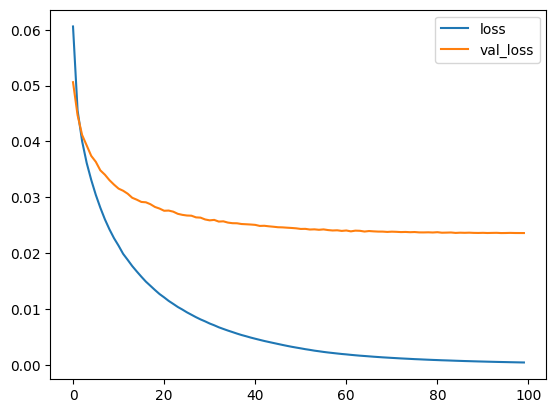

In [29]:
pd.DataFrame(history.history).plot(kind='line')

### END
---